### 주제: 뉴스 토픽 분류 (한국어)
---
- 출처: https://dacon.io/competitions/official/235747/overview/description

In [1]:
# 모듈 로딩
import pandas as pd
import platform
import matplotlib.pyplot as plt
from konlpy.tag import Okt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import SimpleRNN, Embedding, Dense, Dropout, LSTM, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
from tensorflow import random # random seed 설정용

[1] 데이터 준비

In [2]:
# 데이터 로딩
topicDf = pd.read_csv('train_data.csv').iloc[:,1:]
topicDict = pd.read_csv('topic_dict.csv')

In [3]:
topicDf.head()

,title,topic_idx
0,인천→핀란드 항공기 결항…휴가철 여행객 분통,4
1,실리콘밸리 넘어서겠다…구글 15조원 들여 美전역 거점화,4
2,이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것,4
3,NYT 클린턴 측근韓기업 특수관계 조명…공과 사 맞물려종합,4
4,시진핑 트럼프에 중미 무역협상 조속 타결 희망,4


In [4]:
# 결측치 체크
topicDf.isnull().sum()

title        0
topic_idx    0
dtype: int64

In [5]:
# 중복 데이터 체크
topicDf.duplicated().sum()

0

In [6]:
topicDict

,topic,topic_idx
0,IT과학,0
1,경제,1
2,사회,2
3,생활문화,3
4,세계,4
5,스포츠,5
6,정치,6


In [7]:
topic_count = pd.DataFrame(topicDf.topic_idx.value_counts().sort_index())
topic_count['topic'] = topicDict.topic
topic_count

,topic_idx,topic
0,4824,IT과학
1,6222,경제
2,7362,사회
3,5933,생활문화
4,7629,세계
5,6933,스포츠
6,6751,정치


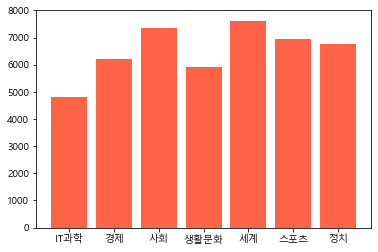

In [8]:
# topic label 분포도
if platform.system()=='Windows':
    plt.rc('font',family='Malgun Gothic')
else:
    plt.rc('font',family='AppleGothic')
        
plt.bar(topic_count.topic, topic_count.topic_idx, color='tomato')
plt.show()

[2] 데이터 처리

In [9]:
# 형태소 분리 객체
okt = Okt()

In [10]:
# 형태소 분리 후 태깅하는 함수
def makeTagging(data):
    result_list = []
    for title in data:
        result = []
        for word in okt.pos(title, stem=True): # 어간 추출
            if word[1] in ['Noun', 'Verb', 'Adjective']: # 'Noun'-명사, 'Verb'-동사, 'Adjective'-형용사 
                if(len(word[0])>1): # 한 글자 단어들 빼줌
                    result.append(word[0])
        result_list.append(result)
    return result_list

In [11]:
result_list = makeTagging(topicDf.title)

In [12]:
# 데이터 확인
for i in range(5):
    print(result_list[i])

['인천', '핀란드', '항공기', '결항', '휴가', '여행객', '분통']
['실리콘밸리', '넘어서다', '구글', '들이다', '전역', '거점']
['이란', '외무', '긴장', '완화', '해결', '미국', '경제', '전쟁', '멈추다']
['클린턴', '측근', '기업', '특수', '관계', '조명', '공과', '맞다', '물리다', '종합']
['시진핑', '트럼프', '중미', '무역', '협상', '조속', '타결', '희망']


In [13]:
# 분리한 단어들로 문장 다시 생성하는 함수
def makeData(data):
    total_list = []
    for stc in data:
        sentence = ''
        for word in stc:
            sentence=sentence+' '+word
        total_list.append(sentence.strip())
    return total_list

In [14]:
total_data = makeData(result_list)

In [15]:
topicDf['new_title'] = total_data

In [16]:
# 데이터 확인
for i in range(5):
    print(topicDf.new_title[i])

인천 핀란드 항공기 결항 휴가 여행객 분통
실리콘밸리 넘어서다 구글 들이다 전역 거점
이란 외무 긴장 완화 해결 미국 경제 전쟁 멈추다
클린턴 측근 기업 특수 관계 조명 공과 맞다 물리다 종합
시진핑 트럼프 중미 무역 협상 조속 타결 희망


In [17]:
# 비율에 맞게 학습/테스트 데이터 분활
X_train, X_test, y_train, y_test = train_test_split(topicDf.new_title, 
                                                    topicDf.topic_idx, 
                                                    test_size=0.2, 
                                                    stratify=topicDf.topic_idx,
                                                    random_state=11)

In [18]:
X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train, 
                                                  test_size=0.2, 
                                                  stratify=y_train,
                                                  random_state=11)

In [19]:
# 인덱스 초기화
X_train = X_train.reset_index().iloc[:,1]
X_test = X_test.reset_index().iloc[:,1]
X_val = X_val.reset_index().iloc[:,1]
y_train = y_train.reset_index().iloc[:,1]
y_test = y_test.reset_index().iloc[:,1]
y_val = y_val.reset_index().iloc[:,1]

In [20]:
print(f'X_train : {X_train.shape}, X_test : {X_test.shape} , X_val : {X_val.shape}')

X_train : (29218,), X_test : (9131,) , X_val : (7305,)


[3] 단어사전 생성

[3-1] 단어사전 생성 및 사용할 단어사전 수 설정

In [21]:
# 단어사전 생성하는 함수
def makeVoca(numWord=0):
    if numWord>0:
        myToken=Tokenizer(num_words=numWord)
    else:
        myToken=Tokenizer()
    
    # 단어사전(voca) 생성
    myToken.fit_on_texts(X_train)   
    return myToken

In [22]:
# 텍스트 데이터 토큰화 진행
myToken=makeVoca()
print('word index: {}'.format(len(myToken.word_index)))

word index: 21285


In [222]:
num_words = 8500
word_counts = dict(myToken.word_counts.items())
counts = list(word_counts.values())

print('전체 토큰 수 :', len(counts))
print('전체 토큰 빈도 수 :',np.sum(counts))
print(num_words,'위까지 등장 토큰 빈도수 :', np.sum(counts[:num_words]))
print('비율 :',np.sum(counts[:num_words])/np.sum(counts) *100 )

전체 토큰 수 : 21285
전체 토큰 빈도 수 : 206147
8500 위 까지 등장 토큰 빈도수 : 176998
비율 : 85.86009012985879


In [24]:
myToken=makeVoca(num_words)
print('word index: {}'.format(len(myToken.word_index)))

word index: 21285


[3-2] 텍스트 => 정수 수치화 (생성한 단어사전 기반)

In [25]:
seq_train=myToken.texts_to_sequences(X_train)
seq_test=myToken.texts_to_sequences(X_test)
seq_val=myToken.texts_to_sequences(X_val)

In [26]:
# 패딩 길이 설정 
def checkLength(datas):
    length = []
    for data in datas:
        length.append(len(data))
    plt.hist(length)
    plt.xlabel('length')
    plt.show()
    return length

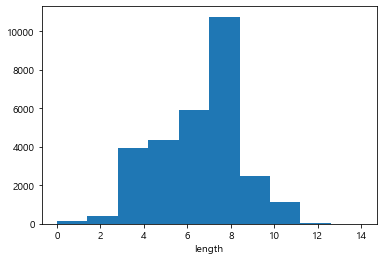

In [27]:
length=checkLength(seq_train)

In [28]:
pad_length = max(length)

In [29]:
train_seq = pad_sequences(seq_train, maxlen=pad_length)
test_seq = pad_sequences(seq_test, maxlen=pad_length)
val_seq = pad_sequences(seq_val, maxlen=pad_length)

In [30]:
train_seq.shape, test_seq.shape, val_seq.shape

((29218, 14), (9131, 14), (7305, 14))

[4] 모델 구성

방법 1. 심플RNN

---

In [31]:
random.set_seed(11)

In [32]:
model = Sequential()
model.add(Embedding(num_words, 32, input_length=pad_length))
model.add(Dropout(0.2))
model.add(SimpleRNN(64))
model.add(Dropout(0.3))
model.add(Dense(7, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 14, 32)            272000    
                                                                 
 dropout (Dropout)           (None, 14, 32)            0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 64)                6208      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 7)                 455       
                                                                 
Total params: 278,663
Trainable params: 278,663
Non-trainable params: 0
_________________________________________________________________


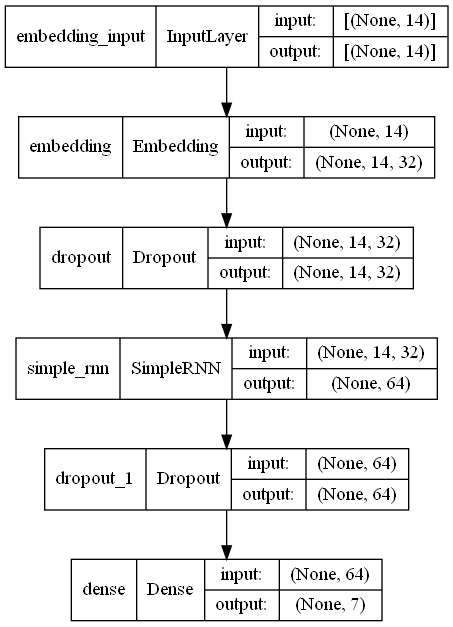

In [33]:
plot_model(model, show_shapes=True)

In [34]:
model.compile(optimizer='rmsprop', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

In [35]:
hist = model.fit(train_seq, y_train, 
                epochs=5, 
                batch_size=64, 
                validation_data=(val_seq, y_val))

Epoch 1/5
457/457 [==============================] - 4s 5ms/step - loss: 1.2902 - accuracy: 0.5077 - val_loss: 0.7947 - val_accuracy: 0.7368
Epoch 2/5
457/457 [==============================] - 2s 5ms/step - loss: 0.6802 - accuracy: 0.7782 - val_loss: 0.8079 - val_accuracy: 0.7251
Epoch 3/5
457/457 [==============================] - 2s 4ms/step - loss: 0.5474 - accuracy: 0.8255 - val_loss: 0.6251 - val_accuracy: 0.7979
Epoch 4/5
457/457 [==============================] - 2s 4ms/step - loss: 0.4802 - accuracy: 0.8497 - val_loss: 0.6250 - val_accuracy: 0.8023
Epoch 5/5
457/457 [==============================] - 2s 4ms/step - loss: 0.4425 - accuracy: 0.8612 - val_loss: 0.6148 - val_accuracy: 0.8073


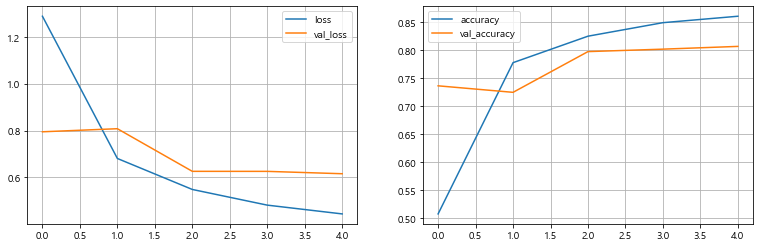

In [36]:
plt.figure(figsize=(13,4))
plt.subplot(121)
plt.plot(hist.epoch, hist.history['loss'])
plt.plot(hist.epoch, hist.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.grid()
plt.subplot(122)
plt.plot(hist.epoch, hist.history['accuracy'])
plt.plot(hist.epoch, hist.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.grid()
plt.show()

In [37]:
model.evaluate(test_seq, y_test)

286/286 [==============================] - 0s 1ms/step - loss: 0.6205 - accuracy: 0.8065


[0.6204554438591003, 0.8064833879470825]

방법 2. 양방향 LSTM

---

In [38]:
random.set_seed(11)

In [44]:
model2 = Sequential()
model2.add(Embedding(num_words, 32, input_length=pad_length))
model2.add(Bidirectional(LSTM(units=64, return_sequences=True)))
model2.add(Dropout(0.3))
model2.add(Bidirectional(LSTM(units=64)))
model2.add(Dropout(0.3))
model2.add(Dense(7, activation='softmax'))

model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 14, 32)            272000    
                                                                 
 bidirectional_2 (Bidirectio  (None, 14, 128)          49664     
 nal)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 14, 128)           0         
                                                                 
 bidirectional_3 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 7)                

In [45]:
model2.compile(optimizer='rmsprop', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

In [46]:
hist2 = model2.fit(train_seq, y_train, 
                epochs=5, 
                batch_size=64, 
                validation_data=(val_seq, y_val))

Epoch 1/5
457/457 [==============================] - 29s 28ms/step - loss: 1.1507 - accuracy: 0.5544 - val_loss: 0.7939 - val_accuracy: 0.7298
Epoch 2/5
457/457 [==============================] - 10s 21ms/step - loss: 0.6185 - accuracy: 0.7966 - val_loss: 0.6598 - val_accuracy: 0.7836
Epoch 3/5
457/457 [==============================] - 11s 23ms/step - loss: 0.4881 - accuracy: 0.8460 - val_loss: 0.5903 - val_accuracy: 0.8040
Epoch 4/5
457/457 [==============================] - 10s 22ms/step - loss: 0.4269 - accuracy: 0.8660 - val_loss: 0.5991 - val_accuracy: 0.8030
Epoch 5/5
457/457 [==============================] - 10s 22ms/step - loss: 0.3887 - accuracy: 0.8775 - val_loss: 0.5829 - val_accuracy: 0.8112


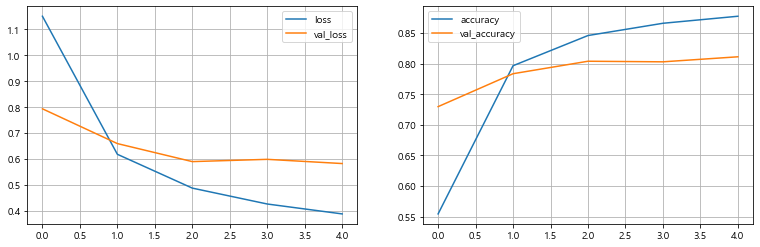

In [47]:
plt.figure(figsize=(13,4))
plt.subplot(121)
plt.plot(hist2.epoch, hist2.history['loss'])
plt.plot(hist2.epoch, hist2.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.grid()
plt.subplot(122)
plt.plot(hist2.epoch, hist2.history['accuracy'])
plt.plot(hist2.epoch, hist2.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.grid()
plt.show()

In [48]:
model2.evaluate(test_seq, y_test)

286/286 [==============================] - 1s 5ms/step - loss: 0.6016 - accuracy: 0.8094


[0.6015506386756897, 0.8094403743743896]

네이버 뉴스 제목 예측

---

In [214]:
news = ["우크라 전쟁에 인공위성 발사 '백지화'…수백억대 비용 '증발' 위험",
        "네이버클라우드, '클라우드 엑스포 아시아' 참가…글로벌 시장 공략",
        '1달러 1440원 치솟았는데…토스증권서는 1298원에 환전 해프닝',
        '삼성전자 언제까지 추락할까…증권가 목표주가 격차 50% 육박',
        '28일 9시까지 3만여명 신규확진 ... 전날보다 4625명 줄어',
        '돈스파이크 구속, 줄 잇는 마약 파문…더 많아지고 더 쉬워졌다',
        '3년만에 가려했더니…부산영화제 예매 첫날부터 오류',
        '경기남부 새벽~아침, 짙은 안개...큰 일교차 주의',
        "'100년 만의 최강 허리케인' 플로리다 전역 비상사태 선포",
        '미, 러 동원령에 "미 시민권자 즉각 러시아 떠나라"',
        "손흥민, '월드컵까지 상승세 탈' EPL 베스트11 선정…전문가 10인 선정",
        '이대호 은퇴식 및 영구결번식, 10월8일 사직구장서 열린다',
        '尹대통령 만난 英외무장관 "여왕 국장 참석, 크게 감동했다"', 
        "이데일리 '외교참사 총책임' 박진, 취임 4개월여 만에 해임 위기"]

In [215]:
news_topic = makeTagging(news)

In [216]:
# 분리한 단어들로 문장 다시 생성하는 함수
def makeData(data):
    total_list = []
    for stc in data:
        sentence = ''
        for word in stc:
            sentence=sentence+' '+word
        total_list.append(sentence.strip())
    return total_list

In [217]:
total_test = makeData(news_topic)

In [218]:
seq_title=myToken.texts_to_sequences(total_test)

In [219]:
title_seq = pad_sequences(seq_title, maxlen=pad_length)

In [221]:
t = []
for i in range(len(title_seq)):
    t.append(model2.predict([title_seq[[i]]]))
topic = {0:'IT과학', 1: '경제', 2:'사회', 3:'생활문화', 4:'세계', 5:'스포츠', 6:'정치'}
origin = ['IT과학', 'IT과학', '경제', '경제', '사회', '사회', '생활문화', '생활문화', '세계', '세계', '스포츠', '스포츠', '정치', '정치', '사회']
topic_idx = ''
for i in range(len(t)):
    topic_idx = (np.argmax(t[i]))
    print('<{}>'.format(news[i]))
    if origin[i] == topic.get(topic_idx): check ='O'
    else: check = 'X'
    print('origin topic: {}, predict topic: {}, check: {}'.format(origin[i], topic.get(topic_idx), check))
    print('-'*50)

<우크라 전쟁에 인공위성 발사 '백지화'…수백억대 비용 '증발' 위험>
origin topic: IT과학, predict topic: 세계, check: X
--------------------------------------------------
<네이버클라우드, '클라우드 엑스포 아시아' 참가…글로벌 시장 공략>
origin topic: IT과학, predict topic: IT과학, check: O
--------------------------------------------------
<1달러 1440원 치솟았는데…토스증권서는 1298원에 환전 해프닝>
origin topic: 경제, predict topic: 경제, check: O
--------------------------------------------------
<삼성전자 언제까지 추락할까…증권가 목표주가 격차 50% 육박>
origin topic: 경제, predict topic: 경제, check: O
--------------------------------------------------
<28일 9시까지 3만여명 신규확진 ... 전날보다 4625명 줄어>
origin topic: 사회, predict topic: 사회, check: O
--------------------------------------------------
<돈스파이크 구속, 줄 잇는 마약 파문…더 많아지고 더 쉬워졌다>
origin topic: 사회, predict topic: 세계, check: X
--------------------------------------------------
<3년만에 가려했더니…부산영화제 예매 첫날부터 오류>
origin topic: 생활문화, predict topic: 생활문화, check: O
--------------------------------------------------
<경기남부 새벽~아침, 짙은 안개...큰 일교차 주의>
origin topic: 생활문화, 

데이콘 test_data.csv로 예측

---

In [49]:
# 데이터 로딩
testDf = pd.read_csv('test_data.csv').iloc[:,1:]
sub = pd.read_csv('sample_submission.csv')

In [50]:
testDf

,title
0,유튜브 내달 2일까지 크리에이터 지원 공간 운영
1,어버이날 맑다가 흐려져…남부지방 옅은 황사
2,내년부터 국가RD 평가 때 논문건수는 반영 않는다
3,김명자 신임 과총 회장 원로와 젊은 과학자 지혜 모을 것
4,회색인간 작가 김동식 양심고백 등 새 소설집 2권 출간
...,...
9126,인천 오후 3시35분 대설주의보…눈 3.1cm 쌓여
9127,노래방에서 지인 성추행 외교부 사무관 불구속 입건종합
9128,40년 전 부마항쟁 부산 시위 사진 2점 최초 공개
9129,게시판 아리랑TV 아프리카개발은행 총회 개회식 생중계


In [51]:
test_list = makeTagging(testDf.title)

In [52]:
# 분리한 단어들로 문장 다시 생성하는 함수
def makeData(data):
    total_list = []
    for stc in data:
        sentence = ''
        for word in stc:
            sentence=sentence+' '+word
        total_list.append(sentence.strip())
    return total_list

In [53]:
total_test = makeData(test_list)

In [54]:
testDf['new_title'] = total_test

In [55]:
# 데이터 확인
for i in range(5):
    print(testDf.new_title[i])

유튜브 내달 크리에이터 지원 공간 운영
어버이날 맑다 흐려지다 남부 지방 옅다 황사
내년 국가 평가 논문 건수 반영 않다
김명자 신임 과총 회장 원로 젊다 과학자 지혜 모으다
회색 인간 작가 동식 양심 고백 소설 추다


In [56]:
seq_title=myToken.texts_to_sequences(testDf.new_title)

In [57]:
title_seq = pad_sequences(seq_title, maxlen=pad_length)

In [60]:
t = []
for i in range(len(title_seq)):
    t.append(model2.predict([title_seq[[i]]]))

In [62]:
topic = []
for i in range(len(t)):
    topic.append(np.argmax(t[i]))

In [63]:
sub['topic_idx'] = topic

In [64]:
sub = sub.set_index(keys='index')

In [65]:
sub.to_csv('제출용3.csv')